# Description of the final project

## Introduction

In this project, you are going to work with the dataset based on the census data extracted from the 1994 and 1995 current population surveys conducted by the U.S. Census Bureau. Your goal is to predict level of income of a person: "- 50000" (means less than \$50k/year) or "50000+" (means more than \$50k/year). The data is split into train (`train.csv`) and test (`test.csv`) parts. You should use train part to train the models, and test part to estimate their final quality. The best quality on the test dataset should be your final result.

The description of the data is available here: https://archive.ics.uci.edu/ml/datasets/Census-Income+%28KDD%29

_Citation:_

* _Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

## Detailed Task Description

The solution should have the following parts:

### [25%] 1. Data exploration

* 1.1. (8%) Which metric are you going to use to evaluate the performance of the model and why?
* 1.2. (8%) Which validation strategy are you going to use and why? Apply it to the data on the preprocessing step
* 1.3. (9%) Explore which features do you have, what is their distribution and connection to the target. Perform feature selection techniques such as PCA, and feature engineering, if necessary. Explain your decisions

### [25%] 2. Data preprocessing

* 2.1. (8%) Fill missing values (if there are any)
* 2.2. (9%) Properly encode categorical features. Explain your choice of methods of categorical feature encoding
* 2.3. (8%) Cluster observations and add cluster number as one of the features. Make sure that the clustering method has a good quality

### [25%] 3. Model training

* 3.1. (8%) Apply different techniques which can help to work with imbalanced data. You are supposed to try at least 2 techniques (in the end, you don't have to include them into your final pipeline - but you should explain why)
* 3.2. (9%) Train different machine learning models, including the advanced boosting algorithms studied during the course. Carefully tune hyperparameters of the algorithms. You are supposed to compare at least 3 models
* 3.3. (8%) Perform blending or stacking of the trained machine learning algorithms. Carefully tune the weights of the ensemble

### [25%] 4. Summary

* 4.1. (8%) Estimate the quality of the models and their ensemble on the test set. Describe the results. Which model is the best?
* 4.2. (8%) Interpret the best single model and the ensemble. Use at least 2 model interpretation techniques. Explain, why your models have good quality (or bad quality)
* 4.3. (9%) Summarize your results and write a conclusion. What have you found in the data, which techniques did you use? Which methods and models worked best in your task? Can you explain in simple words why should we trust your final model?

### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Support all your statements with calculations and plots. For instance, if you claim that the dataset does not have missing values, you need to provide the code which shows that the total number of missing values is zero

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
from sklearn.preprocessing import OrdinalEncoder
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, confusion_matrix, matthews_corrcoef, precision_score, recall_score, f1_score
import itertools
from tqdm import tqdm
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
import re

### Data exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train_path = '/content/drive/My Drive/census-income.data'
test_path = '/content/drive/My Drive/census-income.test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
columns = [
    "age", "class_of_worker", "industry_code", "occupation_code",
    "education", "wage_per_hour", "enroll_in_edu_inst_last_wk",
    "marital_status", "major_industry_code", "major_occupation_code",
    "race", "hispanic_origin", "sex", "member_of_labor_union",
    "reason_for_unemployment", "full_or_part_time_employment_stat",
    "capital_gains", "capital_losses", "dividends_from_stocks",
    "tax_filer_stat", "region_of_previous_residence",
    "state_of_previous_residence", "detailed_household_and_family_stat",
    "detailed_household_summary_in_household", "instance_weight",
    "migration_code_change_in_msa", "migration_code_change_in_reg",
    "migration_code_move_within_reg", "live_in_this_house_1_year_ago",
    "migration_prev_res_in_sunbelt", "num_persons_worked_for_employer",
    "family_members_under_18", "country_of_birth_father",
    "country_of_birth_mother", "country_of_birth_self", "citizenship",
    "own_business_or_self_employed", "fill_inc_questionnaire_for_veterans_admin",
    "veterans_benefits", "weeks_worked_in_year", "year", "income_class"
]

In [ ]:
train = pd.read_csv(train_path, names=columns)

In [ ]:
train.head()

age                  class_of_worker  industry_code  occupation_code  \
0   73                  Not in universe              0                0   
1   58   Self-employed-not incorporated              4               34   
2   18                  Not in universe              0                0   
3    9                  Not in universe              0                0   
4   10                  Not in universe              0                0   

                     education  wage_per_hour enroll_in_edu_inst_last_wk  \
0         High school graduate              0            Not in universe   
1   Some college but no degree              0            Not in universe   
2                   10th grade              0                High school   
3                     Children              0            Not in universe   
4                     Children              0            Not in universe   

   marital_status           major_industry_code  \
0         Widowed   Not in universe or children   
1        Divorced                  Construction   
2   Never married   Not in universe or children   
3   Never married   Not in universe or children   
4   Never married   Not in universe or children   

                  major_occupation_code  ... country_of_birth_father  \
0                       Not in universe  ...           United-States   
1   Precision production craft & repair  ...           United-States   
2                       Not in universe  ...                 Vietnam   
3                       Not in universe  ...           United-States   
4                       Not in universe  ...           United-States   

  country_of_birth_mother country_of_birth_self  \
0           United-States         United-States   
1           United-States         United-States   
2                 Vietnam               Vietnam   
3           United-States         United-States   
4           United-States         United-States   

                            citizenship own_business_or_self_employed  \
0     Native- Born in the United States                             0   
1     Native- Born in the United States                             0   
2   Foreign born- Not a citizen of U S                              0   
3     Native- Born in the United States                             0   
4     Native- Born in the United States                             0   

  fill_inc_questionnaire_for_veterans_admin  veterans_benefits  \
0                           Not in universe                  2   
1                           Not in universe                  2   
2                           Not in universe                  2   
3                           Not in universe                  0   
4                           Not in universe                  0   

   weeks_worked_in_year  year income_class  
0                     0    95     - 50000.  
1                    52    94     - 50000.  
2                     0    95     - 50000.  
3                     0    94     - 50000.  
4                     0    94     - 50000.  

[5 rows x 42 columns]

In [ ]:
test = pd.read_csv(test_path, names=columns)

In [ ]:
print(train['income_class'].value_counts(normalize = True))

 - 50000.    0.937942
 50000+.     0.062058
Name: income_class, dtype: float64


In [ ]:
print(test['income_class'].value_counts(normalize = True))

 - 50000.    0.937992
 50000+.     0.062008
Name: income_class, dtype: float64


#### Metric

 The dataset is highly imbalanced. That's why it's better not to use accuracy. Also from task description it's not clear what is the purpose of the work and what should we care about the most: false positive or false negative results. Considering this information, I decided to use f1-score

#### Validation strategy

Given class imbalance, stratified k-fold is an appropriate strategy. This method ensures that each fold of the dataset has the same proportion of each class as the original dataset

#### Data exploration

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   age                                        199523 non-null  int64  
 1   class_of_worker                            199523 non-null  object 
 2   industry_code                              199523 non-null  int64  
 3   occupation_code                            199523 non-null  int64  
 4   education                                  199523 non-null  object 
 5   wage_per_hour                              199523 non-null  int64  
 6   enroll_in_edu_inst_last_wk                 199523 non-null  object 
 7   marital_status                             199523 non-null  object 
 8   major_industry_code                        199523 non-null  object 
 9   major_occupation_code                      199523 non-null  object 
 10  race    

In [ ]:
train.describe()

age  industry_code  occupation_code  wage_per_hour  \
count  199523.000000  199523.000000    199523.000000  199523.000000   
mean       34.494199      15.352320        11.306556      55.426908   
std        22.310895      18.067129        14.454204     274.896454   
min         0.000000       0.000000         0.000000       0.000000   
25%        15.000000       0.000000         0.000000       0.000000   
50%        33.000000       0.000000         0.000000       0.000000   
75%        50.000000      33.000000        26.000000       0.000000   
max        90.000000      51.000000        46.000000    9999.000000   

       capital_gains  capital_losses  dividends_from_stocks  instance_weight  \
count   199523.00000   199523.000000          199523.000000    199523.000000   
mean       434.71899       37.313788             197.529533      1740.380269   
std       4697.53128      271.896428            1984.163658       993.768156   
min          0.00000        0.000000               0.000000        37.870000   
25%          0.00000        0.000000               0.000000      1061.615000   
50%          0.00000        0.000000               0.000000      1618.310000   
75%          0.00000        0.000000               0.000000      2188.610000   
max      99999.00000     4608.000000           99999.000000     18656.300000   

       num_persons_worked_for_employer  own_business_or_self_employed  \
count                    199523.000000                  199523.000000   
mean                          1.956180                       0.175438   
std                           2.365126                       0.553694   
min                           0.000000                       0.000000   
25%                           0.000000                       0.000000   
50%                           1.000000                       0.000000   
75%                           4.000000                       0.000000   
max                           6.000000                       2.000000   

       veterans_benefits  weeks_worked_in_year           year  
count      199523.000000         199523.000000  199523.000000  
mean            1.514833             23.174897      94.499672  
std             0.851473             24.411488       0.500001  
min             0.000000              0.000000      94.000000  
25%             2.000000              0.000000      94.000000  
50%             2.000000              8.000000      94.000000  
75%             2.000000             52.000000      95.000000  
max             2.000000             52.000000      95.000000

In [ ]:
train['tax_filer_stat'].unique()

array([' Nonfiler', ' Head of household', ' Joint both under 65',
       ' Single', ' Joint both 65+', ' Joint one under 65 & one 65+'],
      dtype=object)

In [ ]:
train['instance_weight'].unique()

array([1700.09, 1053.55,  991.95, ..., 2733.75,  908.14, 4664.87])

In [ ]:
num_cols = [
    "age",
    "wage_per_hour",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "num_persons_worked_for_employer",
    "weeks_worked_in_year"
]



In [ ]:
train['education'].unique()

array([' High school graduate', ' Some college but no degree',
       ' 10th grade', ' Children', ' Bachelors degree(BA AB BS)',
       ' Masters degree(MA MS MEng MEd MSW MBA)', ' Less than 1st grade',
       ' Associates degree-academic program', ' 7th and 8th grade',
       ' 12th grade no diploma', ' Associates degree-occup /vocational',
       ' Prof school degree (MD DDS DVM LLB JD)', ' 5th or 6th grade',
       ' 11th grade', ' Doctorate degree(PhD EdD)', ' 9th grade',
       ' 1st 2nd 3rd or 4th grade'], dtype=object)

In [ ]:
ord_cols = ["education"]

cat_cols = [
    "class_of_worker",
    "industry_code",
    "occupation_code",
    "enroll_in_edu_inst_last_wk",
    "marital_status",
    "major_industry_code",
    "major_occupation_code",
    "race",
    "hispanic_origin",
    "sex",
    "member_of_labor_union",
    "reason_for_unemployment",
    "full_or_part_time_employment_stat",
    "tax_filer_stat",
    "region_of_previous_residence",
    "state_of_previous_residence",
    "detailed_household_and_family_stat",
    "detailed_household_summary_in_household",
    "migration_code_change_in_msa",
    "migration_code_change_in_reg",
    "migration_code_move_within_reg",
    "live_in_this_house_1_year_ago",
    "migration_prev_res_in_sunbelt",
    "family_members_under_18",
    "country_of_birth_father",
    "country_of_birth_mother",
    "country_of_birth_self",
    "citizenship",
    "own_business_or_self_employed",
    "fill_inc_questionnaire_for_veterans_admin",
    "veterans_benefits",
    "year"
]


In [ ]:
def density(column):
    plt.figure(figsize = [10, 5])
    sns.histplot(data = train, x = column, kde = True, bins = 40)
    plt.title(f'density of - {column}', fontsize = 13)
    plt.xlabel('values')
    plt.ylabel('density')
    plt.grid()
    plt.tight_layout()
    plt.show()

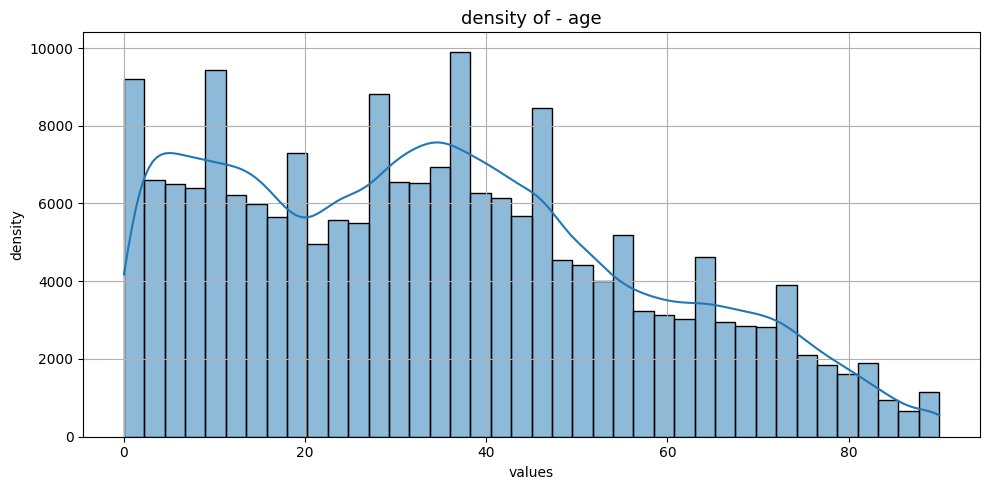

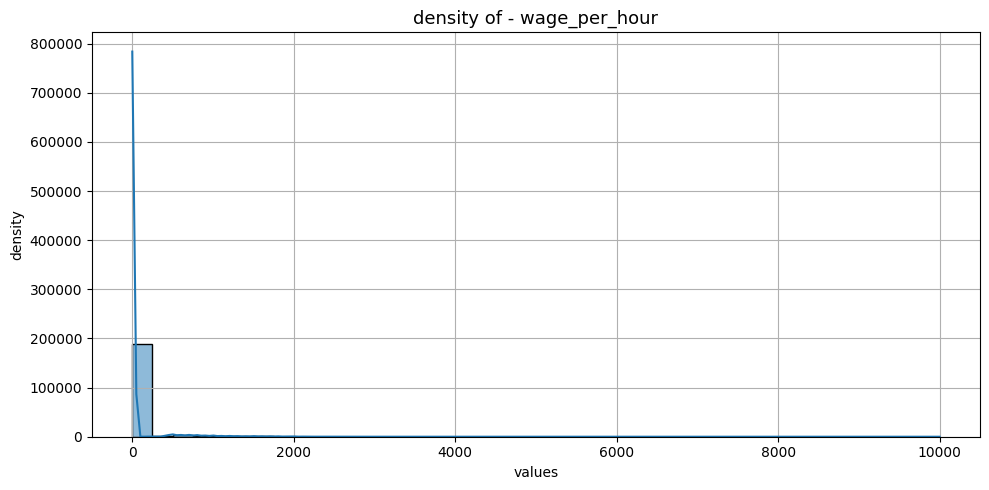

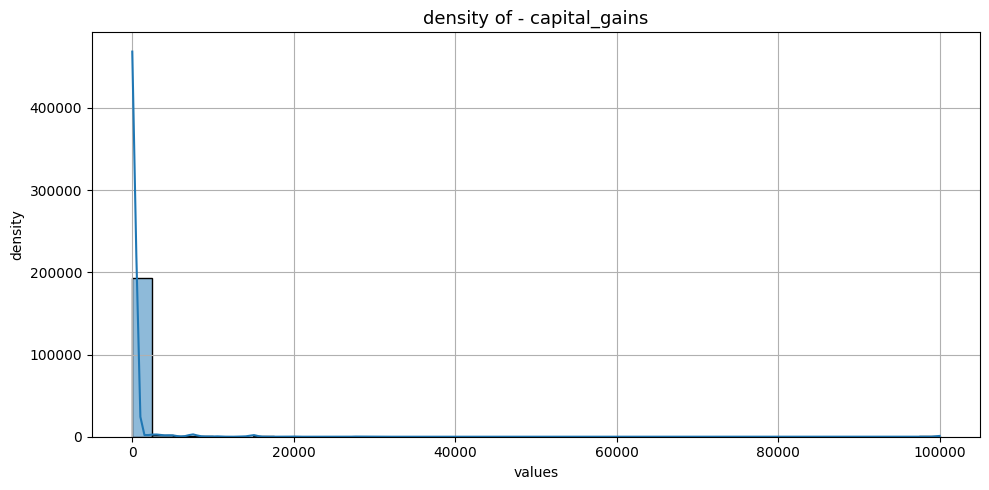

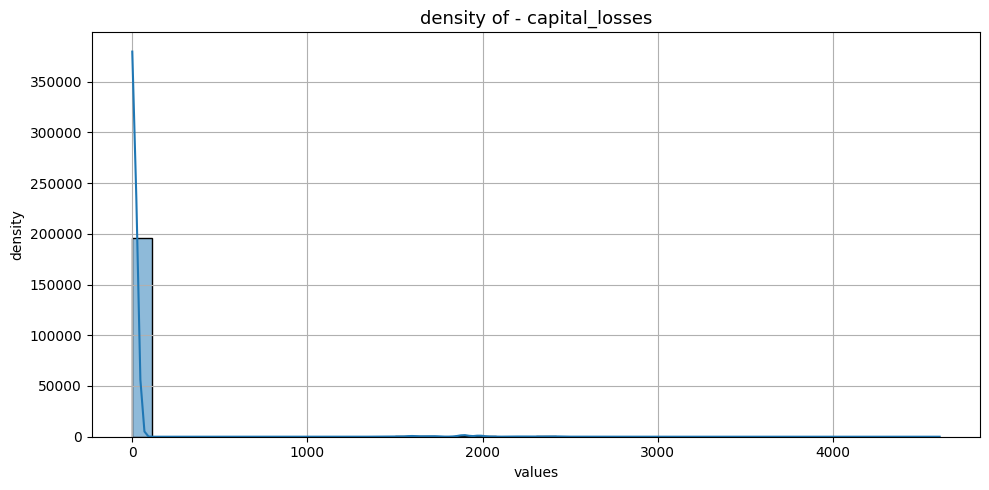

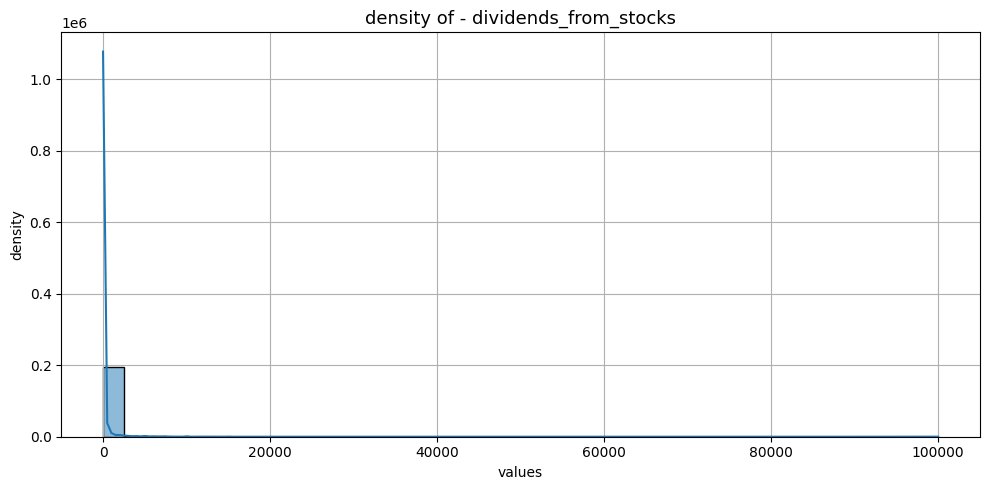

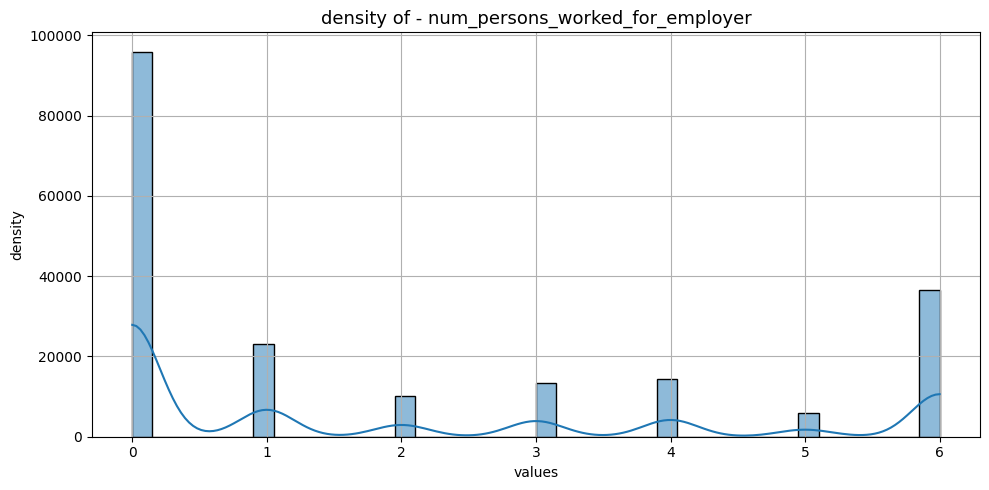

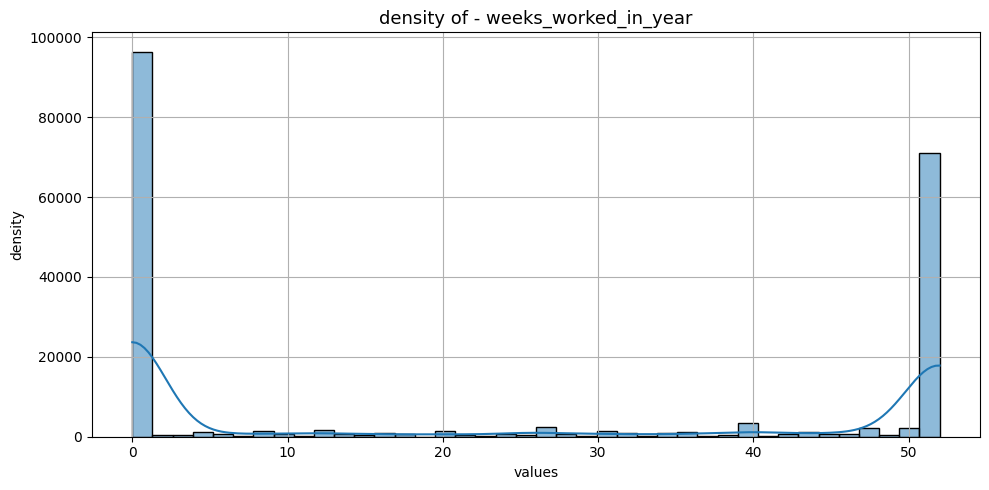

In [ ]:
for i in num_cols:
    density(i)

In [ ]:
def percent(df, column):
    value_counts = df[column].value_counts()
    percentages = (value_counts / len(df)) * 100
    percentages_dict = percentages.to_dict()
    return percentages_dict



In [ ]:
for col in cat_cols:
    percentages = percent(train, col)
    print(f"Column: {col}")
    for key, value in percentages.items():
        print(f"{key}: {value:.2f}%")
    print()

Column: class_of_worker
 Not in universe: 50.24%
 Private: 36.10%
 Self-employed-not incorporated: 4.23%
 Local government: 3.90%
 State government: 2.12%
 Self-employed-incorporated: 1.64%
 Federal government: 1.47%
 Never worked: 0.22%
 Without pay: 0.08%

Column: industry_code
0: 50.46%
33: 8.56%
43: 4.15%
4: 3.00%
42: 2.35%
45: 2.25%
29: 2.11%
37: 2.02%
41: 1.99%
32: 1.80%
35: 1.69%
39: 1.47%
34: 1.39%
44: 1.28%
2: 1.10%
11: 0.88%
50: 0.85%
40: 0.83%
47: 0.82%
38: 0.82%
24: 0.75%
12: 0.68%
19: 0.67%
30: 0.59%
31: 0.59%
25: 0.54%
9: 0.50%
22: 0.48%
36: 0.47%
13: 0.45%
1: 0.41%
48: 0.33%
27: 0.31%
49: 0.31%
3: 0.28%
21: 0.28%
6: 0.28%
5: 0.28%
8: 0.28%
16: 0.27%
23: 0.26%
18: 0.24%
15: 0.23%
7: 0.21%
14: 0.15%
46: 0.09%
17: 0.08%
28: 0.07%
26: 0.06%
51: 0.02%
20: 0.02%
10: 0.00%

Column: occupation_code
0: 50.46%
2: 4.39%
26: 3.95%
19: 2.71%
29: 2.56%
36: 2.08%
34: 2.02%
10: 1.85%
16: 1.73%
23: 1.70%
12: 1.67%
33: 1.67%
3: 1.60%
35: 1.59%
38: 1.51%
31: 1.35%
32: 1.20%
37: 1.12%
8: 1.

In [ ]:
for col in ord_cols:
    percentages = percent(train, col)
    print(f"Column: {col}")
    for key, value in percentages.items():
        print(f"{key}: {value:.2f}%")
    print()

Column: education
 High school graduate: 24.26%
 Children: 23.77%
 Some college but no degree: 13.94%
 Bachelors degree(BA AB BS): 9.96%
 7th and 8th grade: 4.01%
 10th grade: 3.79%
 11th grade: 3.45%
 Masters degree(MA MS MEng MEd MSW MBA): 3.28%
 9th grade: 3.12%
 Associates degree-occup /vocational: 2.69%
 Associates degree-academic program: 2.19%
 5th or 6th grade: 1.64%
 12th grade no diploma: 1.07%
 1st 2nd 3rd or 4th grade: 0.90%
 Prof school degree (MD DDS DVM LLB JD): 0.90%
 Doctorate degree(PhD EdD): 0.63%
 Less than 1st grade: 0.41%



I encoded - 50000 as 0 and 50000+ as 1 for convinience

In [ ]:
train['target_encoded'] = train['income_class'].map({' - 50000.': 0, ' 50000+.': 1})

In [ ]:
test['target_encoded'] = test['income_class'].map({' - 50000.': 0, ' 50000+.': 1})

In [ ]:
train.drop('income_class', axis = 1, inplace = True)
test.drop('income_class', axis = 1, inplace = True)

In [ ]:
cor_matrix = train[num_cols].corr()
cor_matrix

age  wage_per_hour  capital_gains  \
age                              1.000000       0.036938       0.053590   
wage_per_hour                    0.036938       1.000000      -0.001082   
capital_gains                    0.053590      -0.001082       1.000000   
capital_losses                   0.063351       0.010993      -0.012700   
dividends_from_stocks            0.104976      -0.005731       0.131476   
num_persons_worked_for_employer  0.140887       0.191543       0.058015   
weeks_worked_in_year             0.206181       0.195687       0.083549   

                                 capital_losses  dividends_from_stocks  \
age                                    0.063351               0.104976   
wage_per_hour                          0.010993              -0.005731   
capital_gains                         -0.012700               0.131476   
capital_losses                         1.000000               0.042427   
dividends_from_stocks                  0.042427               1.000000   
num_persons_worked_for_employer        0.084255               0.007206   
weeks_worked_in_year                   0.100762               0.013823   

                                 num_persons_worked_for_employer  \
age                                                     0.140887   
wage_per_hour                                           0.191543   
capital_gains                                           0.058015   
capital_losses                                          0.084255   
dividends_from_stocks                                   0.007206   
num_persons_worked_for_employer                         1.000000   
weeks_worked_in_year                                    0.747302   

                                 weeks_worked_in_year  
age                                          0.206181  
wage_per_hour                                0.195687  
capital_gains                                0.083549  
capital_losses                               0.100762  
dividends_from_stocks                        0.013823  
num_persons_worked_for_employer              0.747302  
weeks_worked_in_year                         1.000000

In [ ]:
for col in num_cols:
    corr, p_value = pointbiserialr(train[col], train['target_encoded'])
    print(f"Feature: {col}, correlation: {corr}, p-value: {p_value}")

Feature: age, correlation: 0.13572037728130604, p-value: 0.0
Feature: wage_per_hour, correlation: 0.024528208908773056, p-value: 6.093672346732282e-28
Feature: capital_gains, correlation: 0.24072481971565232, p-value: 0.0
Feature: capital_losses, correlation: 0.1474170755507867, p-value: 0.0
Feature: dividends_from_stocks, correlation: 0.17577945855240024, p-value: 0.0
Feature: num_persons_worked_for_employer, correlation: 0.22268402820146835, p-value: 0.0
Feature: weeks_worked_in_year, correlation: 0.26231613613284327, p-value: 0.0


In [ ]:
for col in cat_cols:
    ct = pd.crosstab(train[col], train['target_encoded'])
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"Chi-squared test for {col}: chi2 stats = {chi2}, p-value = {p}")


Chi-squared test for class_of_worker: chi2 stats = 13542.953108827332, p-value = 0.0
Chi-squared test for industry_code: chi2 stats = 17123.857344994416, p-value = 0.0
Chi-squared test for occupation_code: chi2 stats = 38313.823146534334, p-value = 0.0
Chi-squared test for enroll_in_edu_inst_last_wk: chi2 stats = 822.1126008528602, p-value = 3.0235487355027666e-179
Chi-squared test for marital_status: chi2 stats = 7794.867355272995, p-value = 0.0
Chi-squared test for major_industry_code: chi2 stats = 15404.367654416801, p-value = 0.0
Chi-squared test for major_occupation_code: chi2 stats = 26765.88289440722, p-value = 0.0
Chi-squared test for race: chi2 stats = 688.3644561763933, p-value = 1.1524072977587733e-147
Chi-squared test for hispanic_origin: chi2 stats = 939.1780526455784, p-value = 2.231966827595763e-196
Chi-squared test for sex: chi2 stats = 4955.014384555804, p-value = 0.0
Chi-squared test for member_of_labor_union: chi2 stats = 1122.3023433461378, p-value = 1.9730706157973

As long as all the p-value are < 0.05 and all the correlations are significant I decided not to remove features. I will use PCA for dimencionallity reduction

### Data preprocessing

#### Missing values

In [ ]:
train.isna().sum()

age                                          0
class_of_worker                              0
industry_code                                0
occupation_code                              0
education                                    0
wage_per_hour                                0
enroll_in_edu_inst_last_wk                   0
marital_status                               0
major_industry_code                          0
major_occupation_code                        0
race                                         0
hispanic_origin                              0
sex                                          0
member_of_labor_union                        0
reason_for_unemployment                      0
full_or_part_time_employment_stat            0
capital_gains                                0
capital_losses                               0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
state_of_prev

In [ ]:
test.isna().sum()

age                                          0
class_of_worker                              0
industry_code                                0
occupation_code                              0
education                                    0
wage_per_hour                                0
enroll_in_edu_inst_last_wk                   0
marital_status                               0
major_industry_code                          0
major_occupation_code                        0
race                                         0
hispanic_origin                              0
sex                                          0
member_of_labor_union                        0
reason_for_unemployment                      0
full_or_part_time_employment_stat            0
capital_gains                                0
capital_losses                               0
dividends_from_stocks                        0
tax_filer_stat                               0
region_of_previous_residence                 0
state_of_prev

There are no missing values in both datasets

#### Encoding

I decided to use CatBoost for categorical features with high cardinality. This encoding doesn't increase dimensionality, prevent target leakage and overfitting and relatively not computational expensive. I also have one ordinal feature - enucation, it is encoded with OrdinalEncoder. Features with few categories are encoded with OHE

In [ ]:
#education encoded

education_categories = [' Children', ' Less than 1st grade', ' 1st 2nd 3rd or 4th grade', ' 5th or 6th grade',
                        ' 7th and 8th grade', ' 9th grade', ' 10th grade', ' 11th grade', ' 12th grade no diploma',
                        ' High school graduate', ' Some college but no degree',
                        ' Associates degree-occup /vocational', ' Associates degree-academic program',
                        ' Bachelors degree(BA AB BS)', ' Masters degree(MA MS MEng MEd MSW MBA)',
                        ' Prof school degree (MD DDS DVM LLB JD)', ' Doctorate degree(PhD EdD)'

                       ]

ord_encoder = OrdinalEncoder(categories=[education_categories])

train['education_encoded'] = ord_encoder.fit_transform(train[['education']])
test['education_encoded'] = ord_encoder.transform(test[['education']])

train = train.drop('education', axis=1)
test = test.drop('education', axis=1)

In [ ]:
#Features with few categories

few_cats_cols = ['sex', 'own_business_or_self_employed', 'fill_inc_questionnaire_for_veterans_admin',
                       'veterans_benefits', 'year', 'live_in_this_house_1_year_ago',
                       'migration_prev_res_in_sunbelt', 'member_of_labor_union', 'enroll_in_edu_inst_last_wk']
for col in few_cats_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

for col in few_cats_cols:
    df_col = pd.get_dummies(train[col], prefix=col, drop_first=True, dtype=int)
    train = pd.concat([train, df_col], axis=1)
    train.drop(col, axis=1, inplace=True)


for col in few_cats_cols:
    df_col = pd.get_dummies(test[col], prefix=col, drop_first=True, dtype=int)
    test = pd.concat([test, df_col], axis=1)
    test.drop(col, axis=1, inplace=True)

In [ ]:
#The rest of the eatures encoded

card_cols = ['class_of_worker', 'industry_code', 'occupation_code', 'marital_status', 'major_industry_code',
             'major_occupation_code', 'race', 'hispanic_origin', 'reason_for_unemployment',
             'full_or_part_time_employment_stat', 'tax_filer_stat', 'region_of_previous_residence',
             'state_of_previous_residence', 'detailed_household_and_family_stat',
             'detailed_household_summary_in_household', 'migration_code_change_in_msa',  'citizenship',
             'migration_code_change_in_reg', 'migration_code_move_within_reg', 'family_members_under_18',
             'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self'

]

for col in card_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [ ]:
catboost_encoder = CatBoostEncoder()

for col in card_cols:
    catboost_encoder.fit(train[col], train['target_encoded'])
    train[col] = catboost_encoder.transform(train[col])
    test[col] = catboost_encoder.transform(test[col])

In [ ]:
train.head()

age  class_of_worker  industry_code  occupation_code  wage_per_hour  \
0   73         0.009018       0.008999         0.008999              0   
1   58         0.129063       0.089066         0.074034              0   
2   18         0.009018       0.008999         0.008999              0   
3    9         0.009018       0.008999         0.008999              0   
4   10         0.009018       0.008999         0.008999              0   

   marital_status  major_industry_code  major_occupation_code      race  \
0        0.031543             0.008999               0.008999  0.067350   
1        0.083869             0.089066               0.090794  0.067350   
2        0.012916             0.008999               0.008999  0.073691   
3        0.012916             0.008999               0.008999  0.067350   
4        0.012916             0.008999               0.008999  0.067350   

   hispanic_origin  ...  year_95  \
0          0.06845  ...        1   
1          0.06845  ...        0   
2          0.06845  ...        1   
3          0.06845  ...        0   
4          0.06845  ...        0   

   live_in_this_house_1_year_ago_ Not in universe under 1 year old  \
0                                                  1                 
1                                                  0                 
2                                                  1                 
3                                                  0                 
4                                                  0                 

   live_in_this_house_1_year_ago_ Yes  migration_prev_res_in_sunbelt_ No  \
0                                   0                                  0   
1                                   0                                  0   
2                                   0                                  0   
3                                   1                                  0   
4                                   1                                  0   

   migration_prev_res_in_sunbelt_ Not in universe  \
0                                               0   
1                                               0   
2                                               0   
3                                               1   
4                                               1   

   migration_prev_res_in_sunbelt_ Yes  member_of_labor_union_ Not in universe  \
0                                   0                                       1   
1                                   1                                       1   
2                                   0                                       1   
3                                   0                                       1   
4                                   0                                       1   

   member_of_labor_union_ Yes  enroll_in_edu_inst_last_wk_ High school  \
0                           0                                        0   
1                           0                                        0   
2                           0                                        1   
3                           0                                        0   
4                           0                                        0   

   enroll_in_edu_inst_last_wk_ Not in universe  
0                                            1  
1                                            1  
2                                            0  
3                                            1  
4                                            1  

[5 rows x 50 columns]

In [ ]:
#split the data

y_train = train['target_encoded']
y_test = test['target_encoded']

X_train = train.drop(['target_encoded', 'instance_weight'], axis = 1)
X_test = test.drop(['target_encoded', 'instance_weight'], axis = 1)

weights_train = train['instance_weight']
weights_test = test['instance_weight']

#### PCA

In [ ]:
#Data scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#PCA

pca = PCA(n_components = 0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
X_train.shape[1]

28

In [ ]:
train.shape[1]

50

In [ ]:
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.18386571 0.10893726 0.07908158 0.06486056 0.05598216 0.04736548
 0.03884841 0.03671693 0.02533223 0.02281511 0.02251083 0.02169445
 0.02128579 0.02031974 0.02008289 0.01931819 0.01789705 0.01768885
 0.01684441 0.01561463 0.0146268  0.01440685 0.01320466 0.0114283
 0.01129538 0.01092196 0.00973983 0.00773671]
0.950422760678782


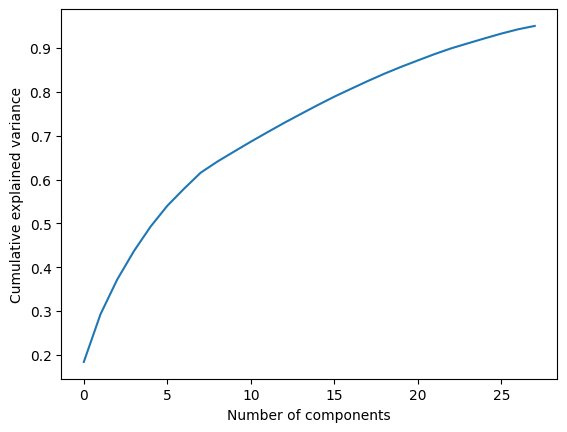

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

#### Clustering
I used HDBSCAN to cluster data

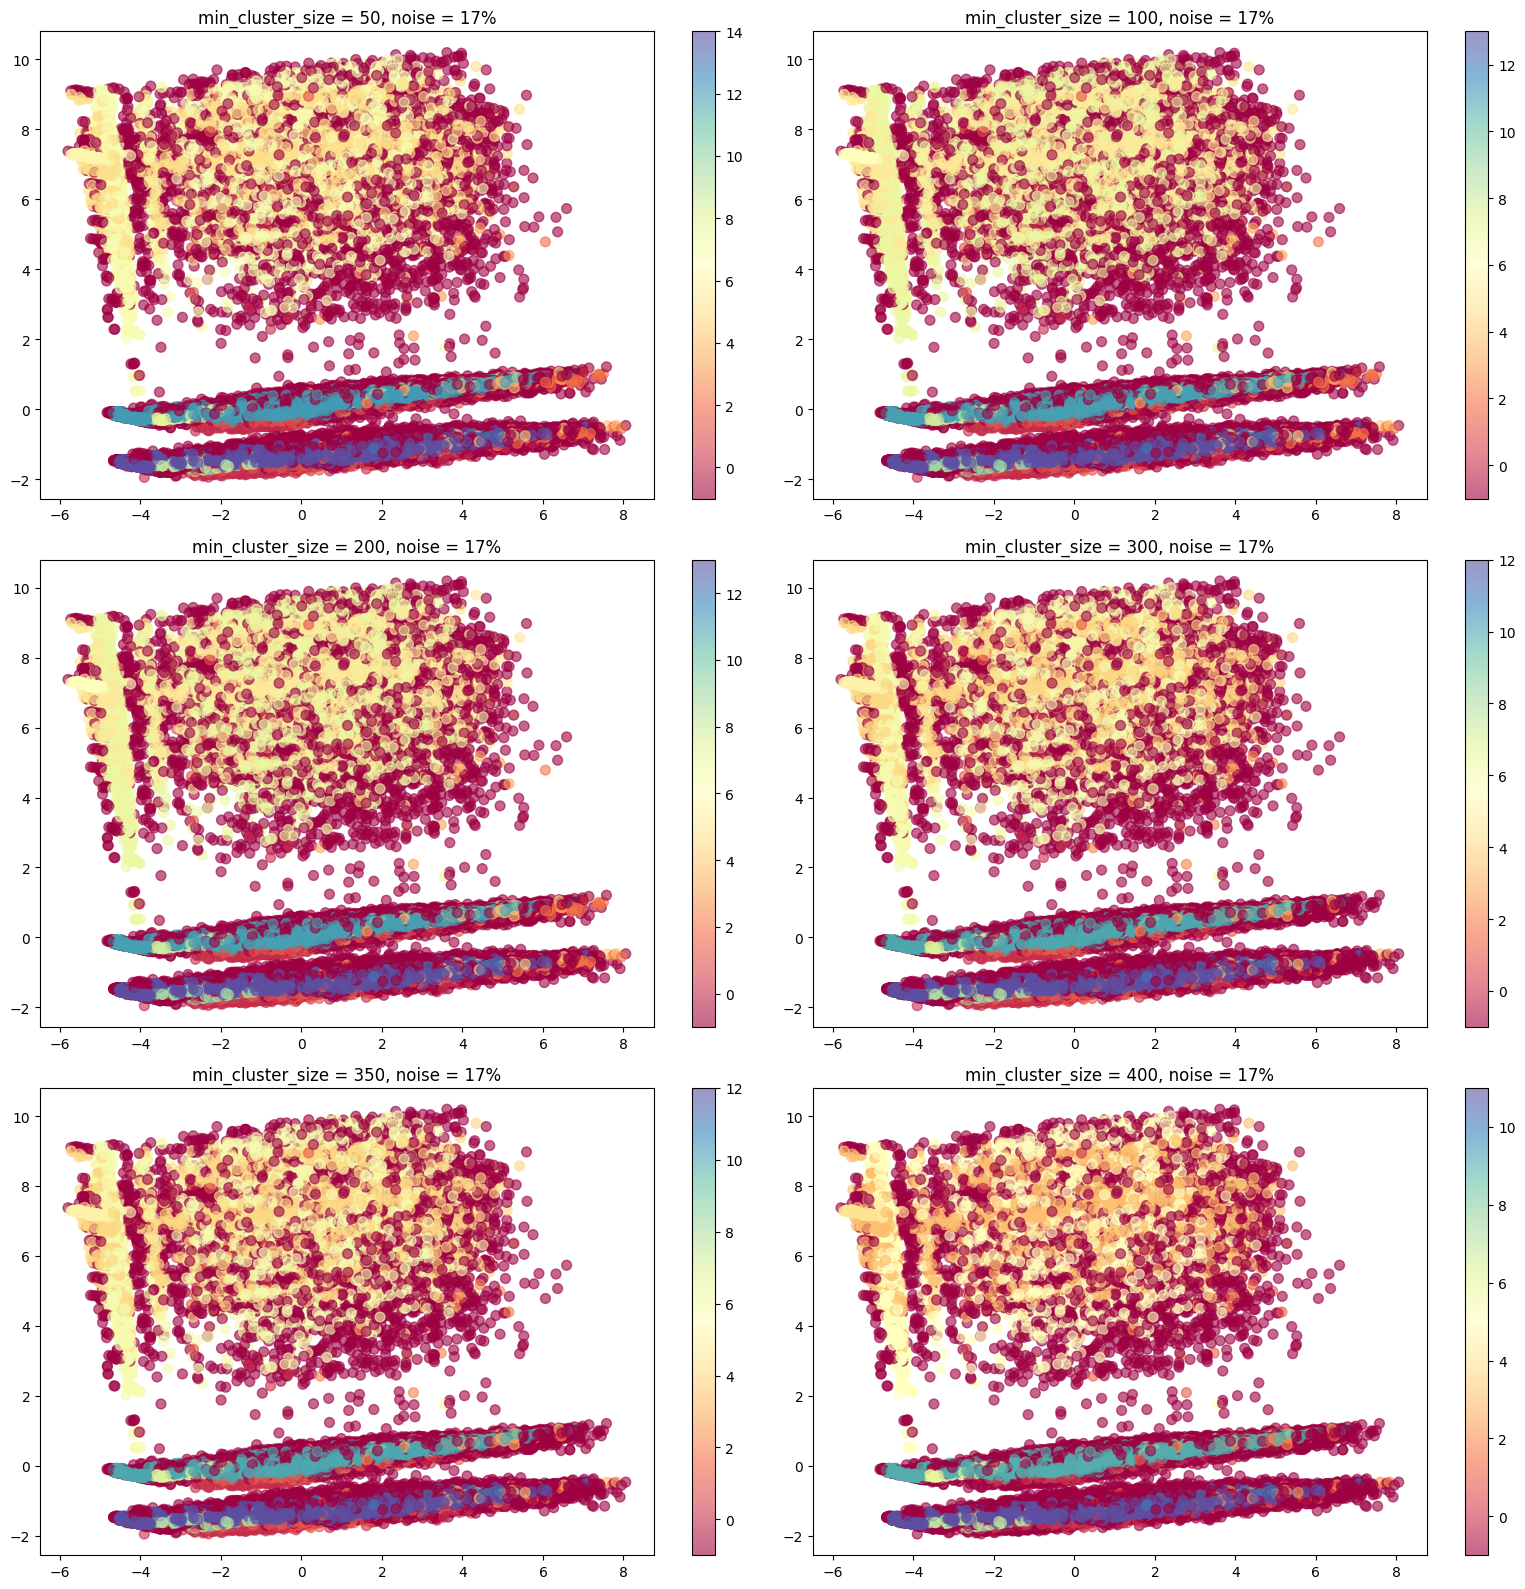

In [ ]:
#Hyperparameters tuning

plt.figure(figsize=(16, 16))

min_samples = 350
cluster_selection_epsilon = 3.5

min_cluster_sizes = [50, 100, 200, 300, 350, 400]

i = 1

for min_cluster_size in min_cluster_sizes:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                min_samples=min_samples,
                                cluster_selection_epsilon=cluster_selection_epsilon)

    clusters = clusterer.fit_predict(X_train)

    plt.subplot(len(min_cluster_sizes) // 2 + len(min_cluster_sizes) % 2, 2, i)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=clusters, cmap='Spectral', s=50, alpha=0.6)
    plt.title(f'min_cluster_size = {min_cluster_size}, noise = {100.0 * np.sum(clusters == -1) / len(X_train):.0f}%')
    plt.colorbar()
    i += 1

plt.tight_layout()
plt.show()


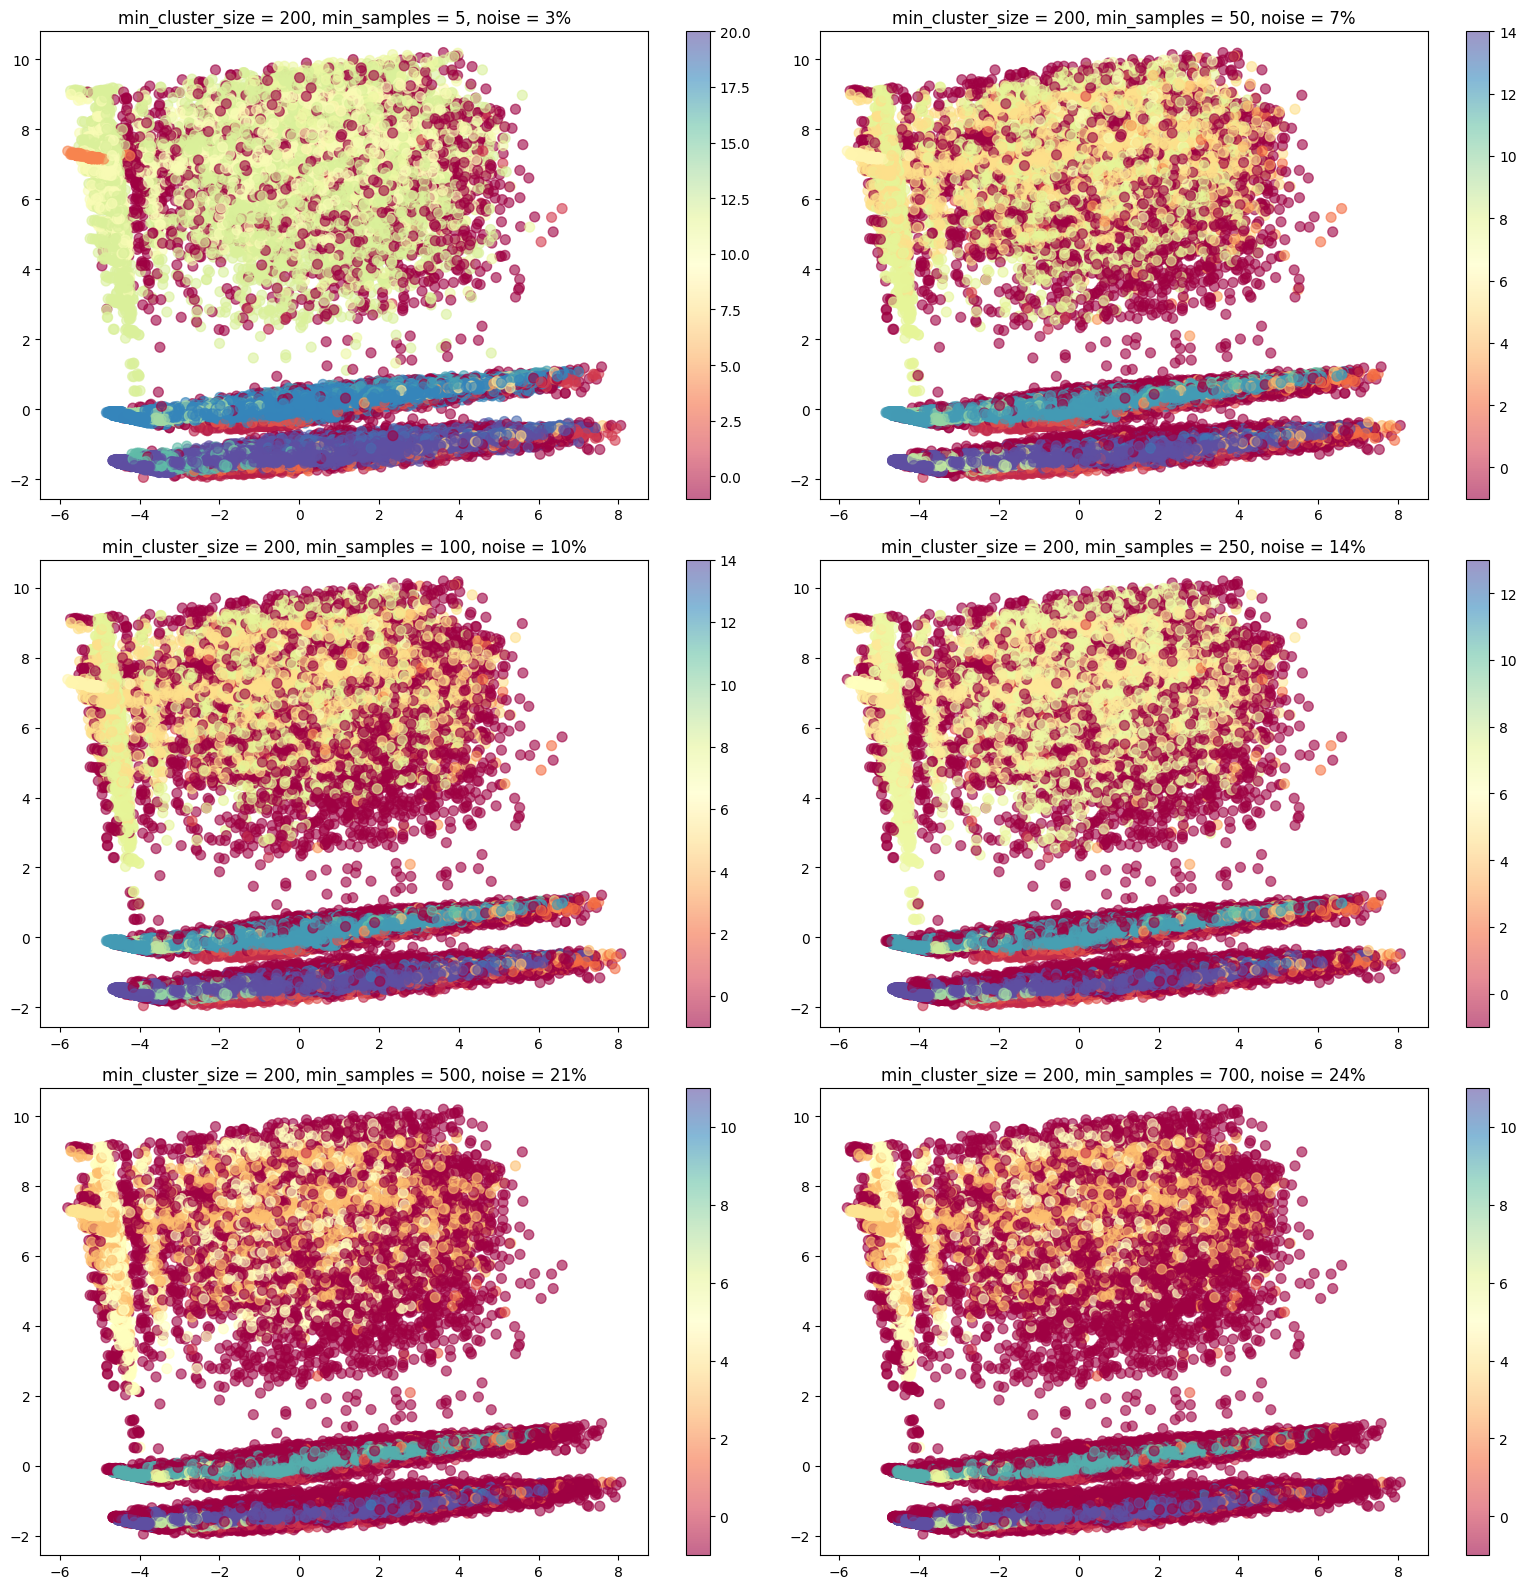

In [ ]:
#Hyperparameters tuning

plt.figure(figsize=(16, 16))

min_cluster_size = 200
cluster_selection_epsilon = 3.5

min_samples = [5, 50, 100, 250, 500, 700]

i = 1

for min_sample in min_samples:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                min_samples=min_sample,
                                cluster_selection_epsilon=cluster_selection_epsilon)

    clusters = clusterer.fit_predict(X_train)

    plt.subplot(3, 2, i)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=clusters, cmap='Spectral', s=50, alpha=0.6)
    plt.title(f'min_cluster_size = {min_cluster_size}, min_samples = {min_sample}, noise = {100.0 * np.sum(clusters == -1) / len(X_train):.0f}%')
    plt.colorbar()
    i += 1

plt.tight_layout()
plt.show()


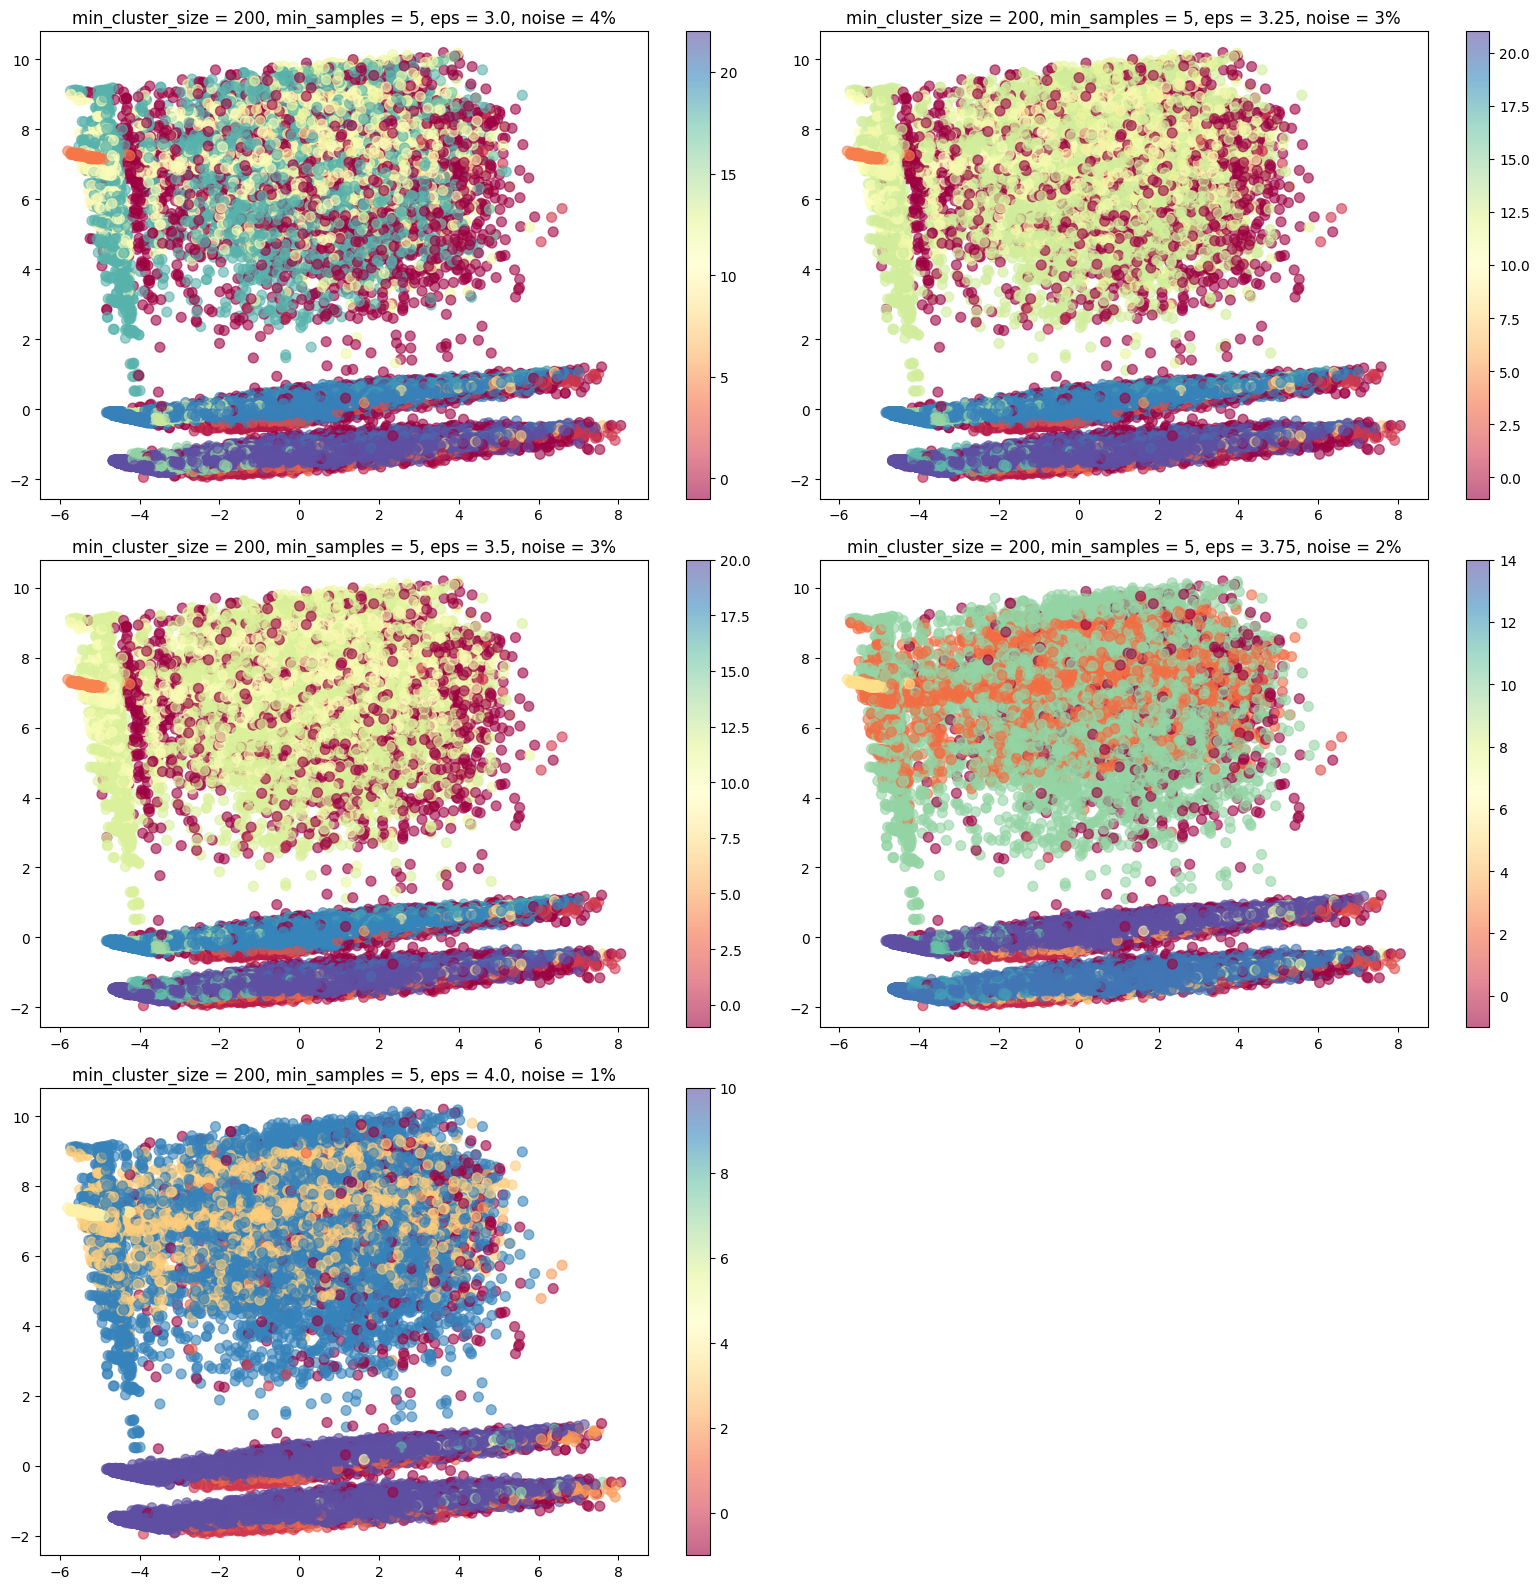

In [ ]:
#Hyperparameters tuning

plt.figure(figsize=(16, 16))

min_cluster_size = 200
min_samples = 5

cluster_selection_epsilon_values = [3.0, 3.25, 3.5, 3.75, 4.0]

i = 1

for cluster_selection_epsilon in cluster_selection_epsilon_values:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                min_samples=min_samples,
                                cluster_selection_epsilon=cluster_selection_epsilon)

    clusters = clusterer.fit_predict(X_train)

    plt.subplot(3, 2, i)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=clusters, cmap='Spectral', s=50, alpha=0.6)
    plt.title(f'min_cluster_size = {min_cluster_size}, min_samples = {min_samples}, eps = {cluster_selection_epsilon}, noise = {100.0 * np.sum(clusters == -1) / len(X_train):.0f}%')
    plt.colorbar()
    i += 1

plt.tight_layout()
plt.show()

In [ ]:
#Calculated silhouette score for parameters with lowest noise

from sklearn.metrics import silhouette_score

clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=5, cluster_selection_epsilon=4.0)
clusters = clusterer.fit_predict(X_train)

if len(set(clusters)) > 1:
    silhouette_avg = silhouette_score(X_train, clusters, metric='euclidean')
else:
    silhouette_avg = -1

silhouette_avg


0.2940835246609323

In [ ]:

clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=5, cluster_selection_epsilon=4)

train_clusters = clusterer.fit_predict(X_train)
tr_cl_col =  train_clusters.reshape(-1, 1)

test_clusters = clusterer.fit_predict(X_test)
te_cl_col = test_clusters.reshape(-1, 1)

X_train = np.concatenate([X_train, tr_cl_col], axis=1)
X_test = np.concatenate([X_test, te_cl_col], axis=1)

### Training
I firstly fitted random forest, catboost classifier, lgbm classifier to unmodified data, then to data after oversampling and undersampling

#### Balancing class weights

In [ ]:
#Random forest - balanced class weights

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
rf = RandomForestClassifier(class_weight = 'balanced', random_state = 42)

f1_scorer = make_scorer(f1_score)
f1_scores = cross_val_score(rf, X_train, y_train, cv=skf, scoring=f1_scorer)

print('Average f1-score ', np.mean(f1_scores))


Average f1-score  0.4511365560777277


In [ ]:
#Random forest - sample_weight specified

f1_scores = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    weights_train_fold = weights_train[train_index]

    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)

    y_pred_fold = rf.predict(X_test_fold)

    f1 = f1_score(y_test_fold, y_pred_fold)
    f1_scores.append(f1)

avg_f1 = np.mean(f1_scores)
print('Average f1-score with sample_weight ', avg_f1)


Average f1-score with sample_weight  0.4967637855958058


In [ ]:
#lgbm - balanced class weights

lgbm = lgb.LGBMClassifier(is_unbalance = True, random_state = 42)

f1_scores = cross_val_score(lgbm, X_train, y_train, cv=skf, scoring = f1_scorer)

print('Average f1-score ', np.mean(f1_scores))

[LightGBM] [Info] Number of positive: 9906, number of negative: 149712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7152
[LightGBM] [Info] Number of data points in the train set: 159618, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062061 -> initscore=-2.715573
[LightGBM] [Info] Start training from score -2.715573
[LightGBM] [Info] Number of positive: 9905, number of negative: 149713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7152
[LightGBM] [Info] Number of data points in the train set: 159618, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062054 -> initscore=-2.715680
[LightGBM] [Info] Start training from score -2.715680
[LightGBM]

In [ ]:
#lgbm - sample_weight specified

f1_scores = []


for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    weights_train_fold = weights_train[train_index]

    lgb_train = lgb.Dataset(X_train_fold, label=y_train_fold, weight=weights_train_fold)

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'is_unbalance': False,
        'seed': 42
    }

    lgbm = lgb.train(params, lgb_train, num_boost_round=100)

    y_pred_fold = lgbm.predict(X_test_fold)
    y_pred_fold_binary = [1 if x >= 0.5 else 0 for x in y_pred_fold]
    f1 = f1_score(y_test_fold, y_pred_fold_binary)
    f1_scores.append(f1)

avg_f1 = np.mean(f1_scores)
print('Average f1-score with sample_weight:', avg_f1)


[LightGBM] [Info] Number of positive: 9906, number of negative: 149712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7152
[LightGBM] [Info] Number of data points in the train set: 159618, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064096 -> initscore=-2.681139
[LightGBM] [Info] Start training from score -2.681139
[LightGBM] [Info] Number of positive: 9905, number of negative: 149713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7152
[LightGBM] [Info] Number of data points in the train set: 159618, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063933 -> initscore=-2.683857
[LightGBM] [Info] Start training from score -2.683857
[LightGBM]

In [ ]:
#catboost - balanced class weights

catboost = CatBoostClassifier(auto_class_weights='Balanced', random_state=42, silent=True)

f1_scores = cross_val_score(catboost, X_train, y_train, cv = skf, scoring = f1_scorer)
print('Average f1-score ', np.mean(f1_scores))

Average f1-score  0.48344909543973047


In [ ]:
#catboost - sample_weights specified

f1_scores = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    weights_train_fold = weights_train[train_index]

    catboost = CatBoostClassifier(verbose=0, random_state=42)

    catboost.fit(X_train_fold, y_train_fold, sample_weight=weights_train_fold)

    y_pred_fold = catboost.predict(X_test_fold)

    f1 = f1_score(y_test_fold, y_pred_fold)
    f1_scores.append(f1)

avg_f1 = np.mean(f1_scores)
print('Average f1-score with sample_weight', avg_f1)

Average f1-score with sample_weight 0.5256091512028087


#### Undersampling

In [ ]:
#Random Forest

f1_scores = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    tl = TomekLinks()
    X_train_resampled, y_train_resampled = tl.fit_resample(X_train_fold, y_train_fold)

    rf = RandomForestClassifier(random_state = 42)

    rf.fit(X_train_resampled, y_train_resampled)

    y_pred_fold = rf.predict(X_test_fold)

    f1 = f1_score(y_test_fold, y_pred_fold)
    f1_scores.append(f1)

avg_f1 = np.mean(f1_scores)
print('Average f1-score:', avg_f1)

Average f1-score: 0.5205100696614694


In [ ]:
#LGBM

f1_scores = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    tl = TomekLinks()
    X_train_resampled, y_train_resampled = tl.fit_resample(X_train_fold, y_train_fold)

    lgb_train = lgb.Dataset(X_train_resampled, label=y_train_resampled)

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'is_unbalance': False,
        'seed': 42
    }

    lgbm = lgb.train(params, lgb_train, num_boost_round=100)

    y_pred_fold = lgbm.predict(X_test_fold)
    y_pred_fold_binary = [1 if x >= 0.5 else 0 for x in y_pred_fold]

    f1 = f1_score(y_test_fold, y_pred_fold_binary)
    f1_scores.append(f1)


avg_f1= np.mean(f1_scores)
print('Average F1-score:', avg_f1)

[LightGBM] [Info] Number of positive: 9906, number of negative: 147168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7152
[LightGBM] [Info] Number of data points in the train set: 157074, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063066 -> initscore=-2.698434
[LightGBM] [Info] Start training from score -2.698434
[LightGBM] [Info] Number of positive: 9905, number of negative: 147159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7152
[LightGBM] [Info] Number of data points in the train set: 157064, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063063 -> initscore=-2.698474
[LightGBM] [Info] Start training from score -2.698474
[LightGBM]

In [ ]:
#CatBoost

f1_scores = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    tl = TomekLinks()
    X_train_resampled, y_train_resampled = tl.fit_resample(X_train_fold, y_train_fold)

    catboost = CatBoostClassifier(random_state=42, silent=True)

    catboost.fit(X_train_resampled, y_train_resampled)

    y_pred_fold = catboost.predict(X_test_fold)

    f1 = f1_score(y_test_fold, y_pred_fold)
    f1_scores.append(f1)

avg_f1 = np.mean(f1_scores)
print('Average f1-score:', avg_f1)

Average f1-score: 0.5453916041598893


#### Oversampling

In [ ]:
#Random Forest

f1_scores = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    smote = SMOTE(sampling_strategy=0.8, k_neighbors=5, random_state=13)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    rf = RandomForestClassifier(random_state = 42)

    rf.fit(X_train_resampled, y_train_resampled)

    y_pred_fold = rf.predict(X_test_fold)

    f1 = f1_score(y_test_fold, y_pred_fold)
    f1_scores.append(f1)

avg_f1 = np.mean(f1_scores)
print('Average f1-score:', avg_f1)

Average f1-score: 0.5308796106903858


In [ ]:
#LGBM

f1_scores = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    smote = SMOTE(sampling_strategy=0.8, k_neighbors=5, random_state=13)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    lgb_train = lgb.Dataset(X_train_resampled, label=y_train_resampled)

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'is_unbalance': False,
        'seed': 42
    }

    lgbm = lgb.train(params, lgb_train, num_boost_round=100)

    y_pred_fold = lgbm.predict(X_test_fold)
    y_pred_fold_binary = [1 if x >= 0.5 else 0 for x in y_pred_fold]

    f1 = f1_score(y_test_fold, y_pred_fold_binary)
    f1_scores.append(f1)


avg_f1= np.mean(f1_scores)
print('Average F1-score:', avg_f1)

[LightGBM] [Info] Number of positive: 119769, number of negative: 149712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7190
[LightGBM] [Info] Number of data points in the train set: 269481, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444443 -> initscore=-0.223149
[LightGBM] [Info] Start training from score -0.223149
[LightGBM] [Info] Number of positive: 119770, number of negative: 149713
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7184
[LightGBM] [Info] Number of data points in the train set: 269483, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444444 -> initscore=-0.223147
[LightGBM] [Info] Start training from score -0.223147
[Light

In [ ]:
#CatBoost

f1_scores = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    smote = SMOTE(sampling_strategy=0.8, k_neighbors=5, random_state=13)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    catboost = CatBoostClassifier(random_state=42, silent=True)

    catboost.fit(X_train_resampled, y_train_resampled)

    y_pred_fold = catboost.predict(X_test_fold)

    f1 = f1_score(y_test_fold, y_pred_fold)
    f1_scores.append(f1)

avg_f1 = np.mean(f1_scores)
print('Average f1-score:', avg_f1)

Average f1-score: 0.4942084022262522


#### Both undersampling and oversampling

In [ ]:
#Random Forest

f1_scores = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    smt = SMOTETomek(sampling_strategy=0.8, random_state=13)
    X_train_resampled, y_train_resampled = smt.fit_resample(X_train_fold, y_train_fold)

    rf = RandomForestClassifier(random_state = 42)

    rf.fit(X_train_resampled, y_train_resampled)

    y_pred_fold = rf.predict(X_test_fold)

    f1 = f1_score(y_test_fold, y_pred_fold)
    f1_scores.append(f1)

avg_f1 = np.mean(f1_scores)
print('Average f1-score:', avg_f1)

Average f1-score: 0.5298504396676997


In [ ]:
#LGBM

f1_scores = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    smt = SMOTETomek(sampling_strategy=0.8, random_state=13)
    X_train_resampled, y_train_resampled = smt.fit_resample(X_train_fold, y_train_fold)

    lgb_train = lgb.Dataset(X_train_resampled, label=y_train_resampled)

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'is_unbalance': False,
        'seed': 42
    }

    lgbm = lgb.train(params, lgb_train, num_boost_round=100)

    y_pred_fold = lgbm.predict(X_test_fold)
    y_pred_fold_binary = [1 if x >= 0.5 else 0 for x in y_pred_fold]

    f1 = f1_score(y_test_fold, y_pred_fold_binary)
    f1_scores.append(f1)


avg_f1= np.mean(f1_scores)
print('Average F1-score:', avg_f1)


[LightGBM] [Info] Number of positive: 119240, number of negative: 149183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7187
[LightGBM] [Info] Number of data points in the train set: 268423, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444224 -> initscore=-0.224035
[LightGBM] [Info] Start training from score -0.224035
[LightGBM] [Info] Number of positive: 119257, number of negative: 149200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7184
[LightGBM] [Info] Number of data points in the train set: 268457, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.444231 -> initscore=-0.224007
[LightGBM] [Info] Start training from score -0.224007
[Light

In [ ]:
#CatBoost

f1_scores = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    smt = SMOTETomek(sampling_strategy=0.8, random_state=13)
    X_train_resampled, y_train_resampled = smt.fit_resample(X_train_fold, y_train_fold)

    catboost = CatBoostClassifier(random_state=42, silent=True)

    catboost.fit(X_train_resampled, y_train_resampled)

    y_pred_fold = catboost.predict(X_test_fold)

    f1 = f1_score(y_test_fold, y_pred_fold)
    f1_scores.append(f1)

avg_f1 = np.mean(f1_scores)
print('Average f1-score:', avg_f1)

Average f1-score: 0.49267208909326


Obtained results:

| Technique | Random Forest | CatBoost | LGBM |
|-----------|---------------|----------|------|
| Class_weight balanced | 0.4511 | 0.4835 | 0.4423 |
| Sample_weight specified | 0.4968 | 0.5256 | 0.5118 |
| Undersampling | 0.5205 | 0.5454 | 0.5345 |
| Oversampling | 0.5309 | 0.4942 | 0.4635 |
| Both over- and undersampling | 0.52985 | 0.4927 | 0.4643 |

The best model is CatBoost trained on undersampled data. The best LGBM was also trained on undersampled data. The best Random Forest was trained on oversampled data

#### Blending

In [ ]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


In [ ]:
smote = SMOTE(sampling_strategy=0.8, k_neighbors=5, random_state=13)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_sub, y_train_sub)

rf = RandomForestClassifier(random_state = 42)

rf.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(random_state=42)

In [ ]:
tl = TomekLinks()
X_train_resampled, y_train_resampled = tl.fit_resample(X_train_sub, y_train_sub)

lgb_train = lgb.Dataset(X_train_resampled, label=y_train_resampled)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': False,
    'seed': 42
}

lgbm = lgb.train(params, lgb_train, num_boost_round=100)


[LightGBM] [Info] Number of positive: 9906, number of negative: 147183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7152
[LightGBM] [Info] Number of data points in the train set: 157089, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063060 -> initscore=-2.698536
[LightGBM] [Info] Start training from score -2.698536


In [ ]:
catboost = CatBoostClassifier(random_state=42, silent=True)

catboost.fit(X_train_resampled, y_train_resampled)

In [ ]:
rf_pred = rf.predict_proba(X_val)[:, 1]
catboost_pred = catboost.predict_proba(X_val)[:, 1]
lgbm_pred = lgbm.predict(X_val)

In [ ]:
X_val_blend = pd.DataFrame({
    'rf': rf_pred,
    'catboost': catboost_pred,
    'lgbm': lgbm_pred
})

In [ ]:
X_val_blend.head()

rf  catboost      lgbm
0  0.00  0.000116  0.000040
1  0.11  0.021412  0.031501
2  0.05  0.010504  0.017917
3  0.51  0.356879  0.464624
4  0.12  0.025971  0.029803

In [ ]:
ensemble_pred = X_val_blend.mean(axis=1)
f1 = f1_score(y_val, ensemble_pred.round())

f1

0.5661482983998197

In [ ]:
weights = np.linspace(0, 1, 101)
all_combinations = itertools.product(weights, repeat=3)

best_f1 = f1
best_weights = (1/3, 1/3, 1/3)

for w in tqdm(all_combinations):
    if sum(w) == 1.0:
        ensemble_prediction = (w[0] * X_val_blend['rf'] +
                               w[1] * X_val_blend['catboost'] +
                               w[2] * X_val_blend['lgbm'])

        f1 = f1_score(y_val, ensemble_prediction.round())

        if f1 > best_f1:
            best_f1 = f1
            best_weights = w

print(f"Best F1-score: {best_f1:.5f} with weights: {best_weights}")

1030301it [01:40, 10295.04it/s] 

Best F1-score: 0.57416 with weights: (0.43, 0.07, 0.5)


In [ ]:
ensemble_val_pred = 0.43 * rf_pred + 0.07 * catboost_pred + 0.5 * lgbm_pred

best_f1 = 0
best_threshold = 0.5

for threshold in np.linspace(0.1, 0.9, 17):
    val_pred_binary = (ensemble_val_pred >= threshold).astype(int)

    f1 = f1_score(y_val, val_pred_binary)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Best threshold: {best_threshold:.5f}, best f1-score: {best_f1:.5f}')



Best threshold: 0.45000, best f1-score: 0.57534


### Summary

#### Testing

In [ ]:
rf_test = rf.predict_proba(X_test)[:, 1]
catboost_test = catboost.predict_proba(X_test)[:, 1]
lgbm_test = lgbm.predict(X_test)

In [ ]:
ensemble_test = 0.43 * rf_test + 0.07 * catboost_test + 0.5 * lgbm_test
y_pred = (ensemble_test >= 0.45).astype(int)


In [ ]:
def compute_metrics(y_test, y_pred):
    print('Accuracy: {:.5f}'.format(accuracy_score(y_test, y_pred)))
    print('F-score: {:.5f}'.format(f1_score(y_test, y_pred)))
    print('Precision: {:.5f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.5f}'.format(recall_score(y_test, y_pred)))
    print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_test, y_pred)))
    print('MCC: {:.5f}'.format(matthews_corrcoef(y_test, y_pred)))

def compute_confusion_matrix(y_test, y_pred):
    compute_metrics(y_test, y_pred)
    return pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=[1, 0]),
        columns=['a(x) = 1', 'a(x) = 0'],
        index=['y = 1', 'y = 0'],
    ).T

In [ ]:
compute_confusion_matrix(y_test, y_pred)

Accuracy: 0.94644
F-score: 0.57287
Precision: 0.56666
Recall: 0.57921
Accuracy (balanced): 0.77497
MCC: 0.54434


y = 1  y = 0
a(x) = 1   3583   2740
a(x) = 0   2603  90836

#### Interpretation

##### CatBoost interpretation

In [ ]:
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_val)

In [ ]:
loadings = pca.components_

In [ ]:
shap_pca = shap_values[:, :-1]
shap_cluster = shap_values[:, -1]

In [ ]:
importance = np.dot(shap_pca, loadings)

importance_sum = np.sum(importance, axis=0)
features = train.drop(['target_encoded', 'instance_weight'], axis = 1)

feature_names = features.columns
importance_dict = dict(zip(feature_names, importance_sum))

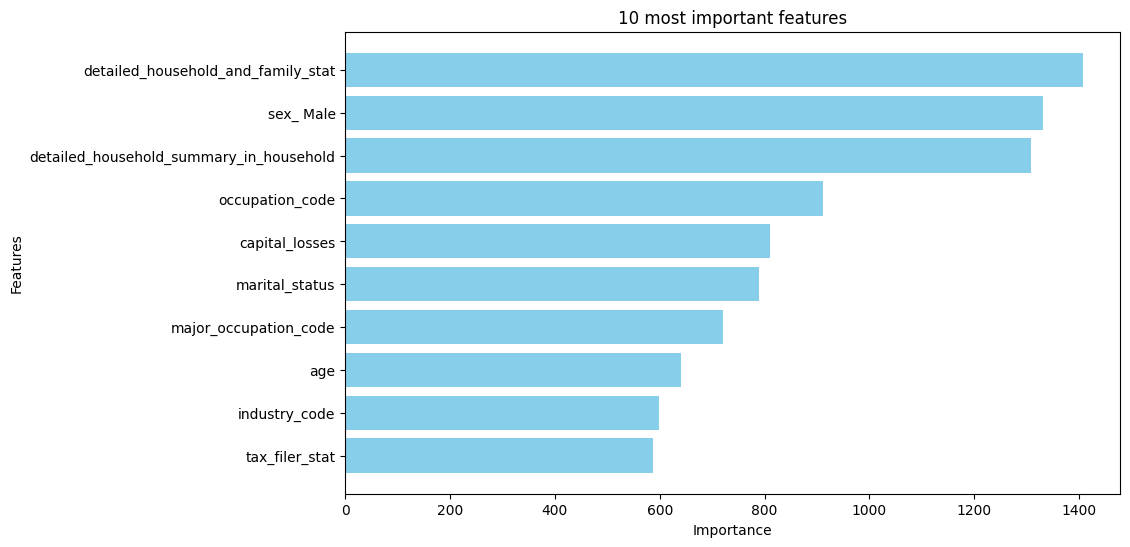

In [ ]:
importance_dict = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)
top10 = importance_dict[:10]

feature_names, importances = zip(*top10)


plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('10 most important features')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
num_features = features.shape[1]

feature_names = [f'pca_{i}' for i in range(1, num_features + 1)]
feature_names.append('cluster')

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = X_train,
    feature_names = feature_names,
    mode='classification'
)


instance_idx = 10
instance = X_val[instance_idx]


exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=catboost.predict_proba
)


explanation_list = exp.as_list()




In [ ]:
explanation_list

[('pca_1 <= -3.36', -0.0985506363191061),
 ('pca_7 <= -0.87', -0.030410438232763484),
 ('pca_10 <= -0.55', -0.026661319289143243),
 ('pca_12 > 0.12', 0.013696993687262814),
 ('-0.11 < pca_9 <= 0.55', -0.01290106315954889),
 ('0.27 < pca_4 <= 0.84', 0.01139416451281084),
 ('-0.37 < pca_16 <= -0.05', 0.010373792142257676),
 ('-0.17 < pca_8 <= 0.33', 0.008138125975090222),
 ('-0.14 < pca_28 <= 0.05', -0.007650126354338635),
 ('pca_6 > 0.52', -0.007289498345104183)]

In [ ]:
importance_original = np.zeros(loadings.shape[0])

for feature_importance in explanation_list:
    match = re.search(r'pca_(\d+)', feature_importance[0])
    if match:
        component_idx = int(match.group(1)) - 1
        component_importance = feature_importance[1]

        for i in range(loadings.shape[0]):
            importance_original[i] += loadings[i, component_idx] * component_importance


In [ ]:
importance_original

array([-0.02049143,  0.00195008, -0.01626257, -0.01873418, -0.0321792 ,
        0.01744978, -0.00789585, -0.01058381, -0.00044326, -0.00361263,
        0.00083245,  0.00140658,  0.00171593, -0.00061149, -0.00731006,
        0.00273787, -0.00219068, -0.00393192,  0.00182085,  0.00426762,
       -0.00318104, -0.00367242,  0.03251018,  0.0076751 ,  0.02373355,
        0.02366824, -0.02154701,  0.00498939])

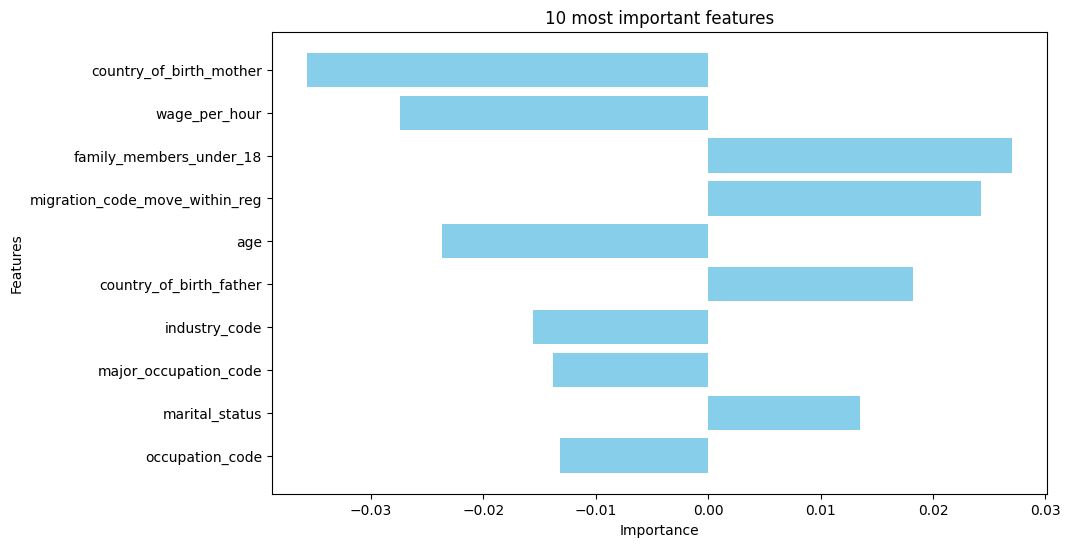

In [ ]:
cols = features.columns.tolist()

importance_dict = {name: imp for name, imp in zip(cols, importance_original)}
top10 = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
feature_names, importances = zip(*top10)

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('10 most important features')
plt.gca().invert_yaxis()
plt.show()

##### Ensemble interpretation

In [ ]:
feature_names = [f'pca_{i}' for i in range(1, num_features + 1)]

In [ ]:
def ensemble_predict(samples):
    rf_probs = rf.predict_proba(samples)[:, 1]
    catboost_probs = catboost.predict_proba(samples)[:, 1]
    lgbm_probs = lgbm.predict(samples)

    ensemble_probs = 0.43 * rf_probs + 0.07 * catboost_probs + 0.5 * lgbm_probs
    return np.vstack((1 - ensemble_probs, ensemble_probs)).T


explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    mode='classification'
)

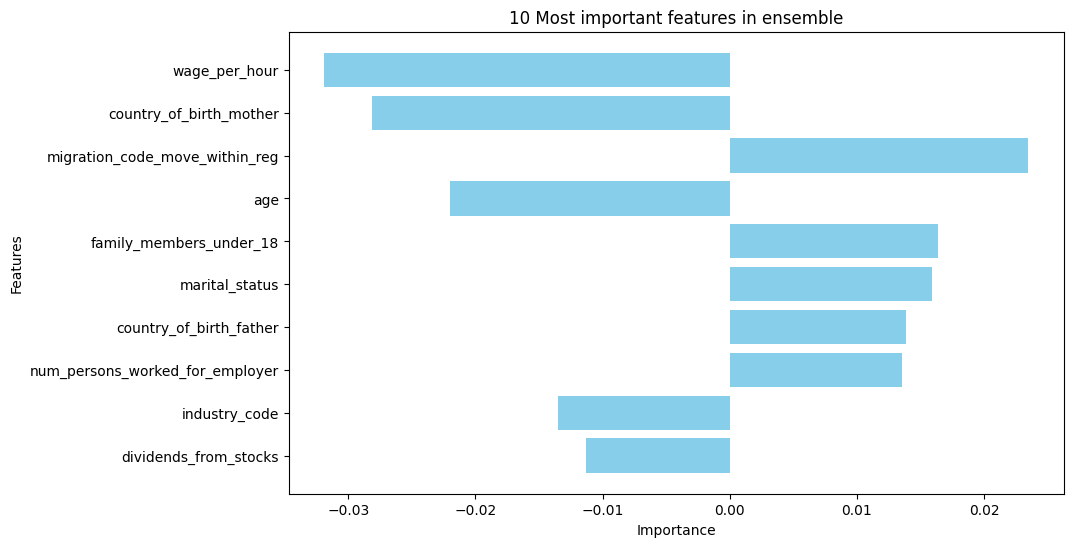

In [ ]:
instance_idx = 10
instance = X_val[instance_idx]


exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=ensemble_predict
)

explanation_list = exp.as_list()
importance_original = np.zeros(loadings.shape[0])

for feature_importance in explanation_list:
    match = re.search(r'pca_(\d+)', feature_importance[0])
    if match:
        component_idx = int(match.group(1)) - 1
        component_importance = feature_importance[1]

        for i in range(loadings.shape[0]):
            importance_original[i] += loadings[i, component_idx] * component_importance


importance_dict = {name: imp for name, imp in zip(cols, importance_original)}
top10 = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
feature_names, importances = zip(*top10)

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('10 Most important features in ensemble')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
#I used this simple approach because computing SHAP values and permutation importance was too computationaly expensive

rf_importance = rf.feature_importances_[:-1]
catboost_importance = catboost.feature_importances_[:-1]
lgbm_importance = lgbm.feature_importance()[:-1]


weighted_importance = 0.43 * rf_importance + 0.07 * catboost_importance + 0.5 * lgbm_importance

importances = np.dot(weighted_importance, loadings)

importances

array([ 40.12428758,  57.02991574,   8.74995578,  32.33342254,
       111.23159344,  73.96764644,  11.9567817 ,  33.28620167,
         3.61863912, -10.46832573, -43.81714265,  14.25267265,
        19.66665751,  19.39926579, 176.45689219,  56.20630277,
       -12.34893383, -15.8674095 ,  75.08228905,  67.22306939,
        -3.6845317 ,  -2.05035623,  -2.22516389, -29.31595311,
        24.1685609 ,  19.29559814,  21.45873107,  36.32039991,
        16.7063721 ,  14.13162087,  30.01507356, -55.30683439,
       -27.64186096,  42.77356388, -29.16767816,  69.80760849,
        29.16767816,  29.26669455, -24.25485397, -26.43999408,
        21.19704861,  -1.3742796 ,  18.93254712,  18.3481607 ,
       -43.10761445,  16.87087322,  51.43301705, -16.60204392])

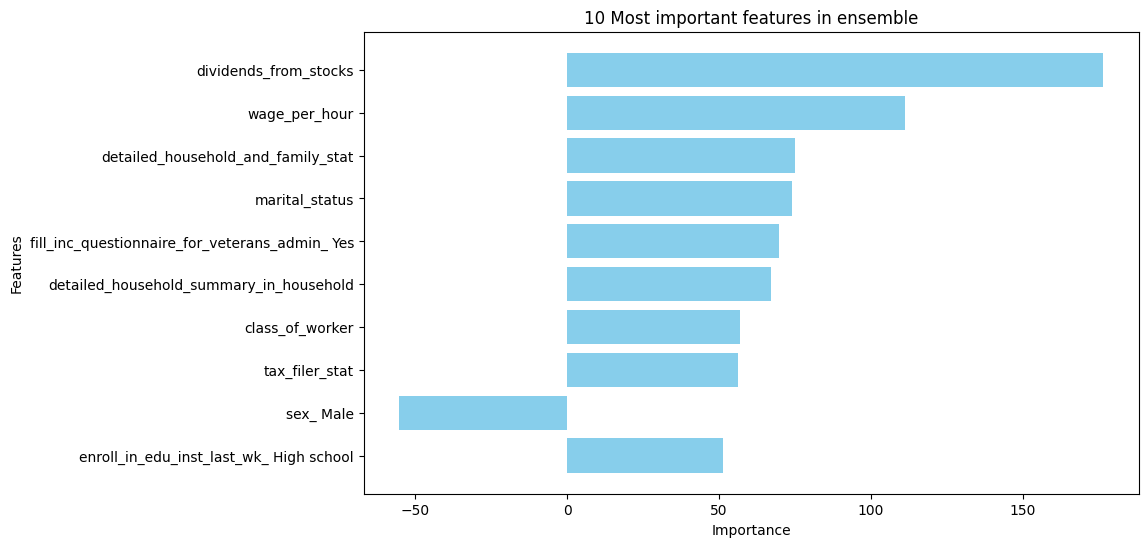

In [ ]:
feature_names = features.columns.tolist()

importance_dict = dict(zip(feature_names, importances))

sorted_feature_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

top10 = sorted(importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
feature_names, importances = zip(*top10)

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('10 Most important features in ensemble')
plt.gca().invert_yaxis()
plt.show()

#### Conclusion

In this task I built a model to predict whether income of a person exceeds 50k/year or not.

On the preprocessing step I dropped variable instance_weight, encoded categorical features with catboost, ordinal and OHE encodings. I noticed that all the features correlated with target variable significantly, due to that fact, I didn't remove any feature. I applied PCA to reduce dimensionality then. Finally, I performed clustering and added a new feature to the dataset - cluster label.

I trained three models: Random Forest Classifier, CatBoost Classifier and LGBM Classifier. I used different techniques to handle class imbalance. The best result was shown by  CatBoost trained on undersampled data. The best LGBM was also trained on undersampled data. The best Random Forest was trained on oversampled data.

Then I blended these three best models into ensemble, tuned weights of each model prediction and threshold for positive class probability. the best results I achived:
* Accuracy: 0.94644
* F-score: 0.57287
* Precision: 0.56666
* Recall: 0.57921
* Accuracy (balanced): 0.77497
* MCC: 0.54434

Ensemble quite accurate predicts negative class, but it's performance is moderate for positive class prediction, so there is a room for improvement. It's reasonable to try other models, different encoding techiques. Maybe performance would be better without PCA. Possibly the issue lies in a format of target varible: two pearsos with income 49000 and 50500 are assigned to different classes, but the differece is small and they might be quite simmilar in terms of features values and models may have difficulty to capture such a subtle difference.

To conclude, ensemble is quite reliable to predict negative class, but positive class prediction should be interpreted with caution.
